# Extracting a pore network using PoreSpy and loading into OpenPNM


In [1]:
import warnings
import scipy as sp
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
ws = op.Workspace()
ws.settings["loglevel"] = 40
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(10)

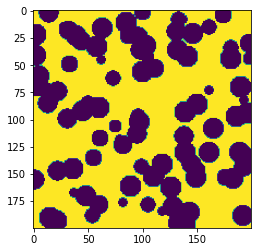

In [2]:
# NBVAL_IGNORE_OUTPUT
im = ps.generators.overlapping_spheres(shape=[200, 200, 200], r=10, porosity=0.5, maxiter=0)
plt.imshow(im[:, :, 50]);

Let's check out the porosity of the generated image!

In [3]:
eps = ps.metrics.porosity(im)
print(f"Porosity: {eps*100:.1f}%")

Porosity: 62.0%


Let's visualize the image using `porespy`'s 3D visualizer: (this might take several seconds)

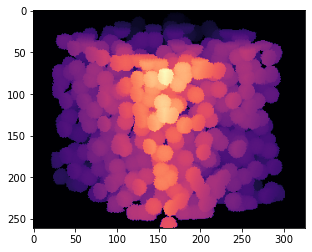

In [4]:
# NBVAL_IGNORE_OUTPUT
im_3d = ps.visualization.show_3D(im)
plt.imshow(im_3d, cmap=plt.cm.magma);

In [5]:
# NBVAL_IGNORE_OUTPUT
snow = ps.networks.snow2(im, boundary_width=[[0, 3], 0, 0])

Extracting pore and throat properties:   0%|          | 0/705 [00:00<?, ?it/s]

OpenPNM has an IO class specifically for importing the output from PoreSpy.  The ``import_data`` method can either accept a handle to a dictionary (as output from the ``snow`` algorithm above), or it can accept a filename to a saved dctionary (saved using Python's ``pickle`` library).  All IO methods in OpenPNM return a ``project`` which is a ``list``, in this case containing a network and a geometry object.  

In [6]:
# NBVAL_IGNORE_OUTPUT
proj = op.io.PoreSpy.import_data(snow.network)
print(proj)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 Object Name     Object ID                                                        
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 net_01          <openpnm.network.GenericNetwork object at 0x24b943e5680>         
 geo_01          <openpnm.geometry.Imported object at 0x24b942bbf40>              
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


We can unpack the network and geometry objects from the ``project`` using the indices in the list as follows:

In [7]:
# NBVAL_IGNORE_OUTPUT
net = proj[0]
geo = proj[1]
print(net)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.GenericNetwork : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                     705 / 705  
2     pore.region_label                               705 / 705  
3     throat.conns                                   2533 / 2533 
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      705       
2     pore.boundary                                 56        
3     pore.geo_01                                   705       
4     pore.xmax                           

It is important to note that the ``net`` object only has topological information and labels.  The ``geo`` object was created by the ``openpnm.io.PoreSpy`` import class to extract all geometric information from the supplied ``snow`` dict and put in on a geometry object.  We can print ``geo`` to confirm:

In [8]:
# NBVAL_IGNORE_OUTPUT
print(geo)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.geometry.Imported : geo_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.diameter                                   705 / 705  
2     pore.equivalent_diameter                        705 / 705  
3     pore.extended_diameter                          705 / 705  
4     pore.geometric_centroid                         705 / 705  
5     pore.global_peak                                705 / 705  
6     pore.inscribed_diameter                         705 / 705  
7     pore.local_peak                                 705 / 705  
8     pore.phase                                      705 / 705  
9     pore.region_volume                              705 / 705  
10    pore.surface_area                               705 / 705  
11 

Now let's plot things to see what we have:

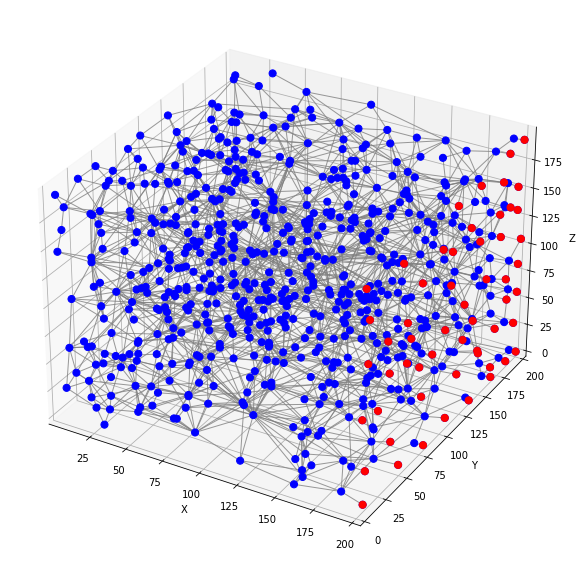

In [9]:
# NBVAL_IGNORE_OUTPUT
fig = op.topotools.plot_connections(network=net, alpha=0.8, color='grey')
fig = op.topotools.plot_coordinates(network=net, fig=fig, color='b', markersize=50)
fig = op.topotools.plot_coordinates(network=net, pores=net.pores('xmax'), fig=fig, color='r', markersize=50)
fig.set_size_inches(8, 8)
fig.tight_layout()

This looks pretty good, but it only has boundary pores on the right face, indicated by the red dots.  When we ran the ``snow`` algorithm we specifically told it to only put boundary pores the ``"right"``.  We could have added them to all faces during the extraction, but for the sake of demonstration we can add them after the fact, although the result is slightly different, as you'll see.  

We'll use the ``find_surface_pores`` function in the ``topotools`` module.  This function applies a Delaunay tessellation between the interior pores and some fictitious "marker" nodes.  Only pores that are on the surface will be connected to these marker nodes.  To get the best result from the ``find_surface_pores`` function, it's a good idea to supply your own markers, so let's make a 2D plane of points, positioned outside the left face of the domain:

In [10]:
m = np.meshgrid(range(50, 195, 10), range(50, 195, 10))
m = np.vstack([-10*np.ones_like(m[0].flatten()), m[0].flatten(), m[1].flatten()]).T

Now we pass these points in as markers to the ``find_surface_pores`` function:

In [11]:
op.topotools.find_surface_pores(network=net, markers=m, label='left')

Lastly we want to "clone" these pores and translate them to domain edge:

In [12]:
op.topotools.clone_pores(network=net, pores=net.pores('left'), labels='left_boundary')
net['pore.coords'][net.pores('left_boundary')] *= [0, 1, 1]

Now let's inspect the result using the quick plotting tools in the ``topotools`` module.  First we'll add a new label called ``'right_boundary'`` to match the ``'left_boundary'`` we added above, then we'll plot the throats that connect to ther ``'right_boundary'`` or ``'left_boundary'``:

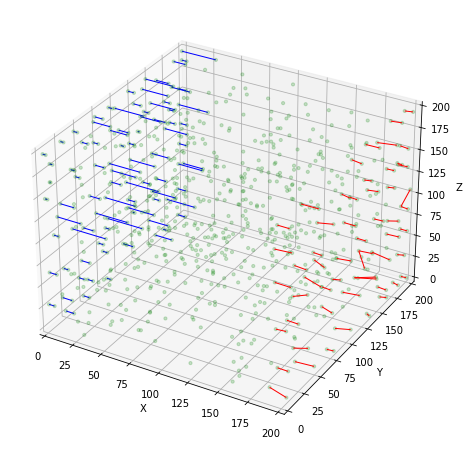

In [13]:
# NBVAL_IGNORE_OUTPUT
Ps = net.pores('xmax')
net.set_label('right_boundary', pores=Ps)
Ts = net.find_neighbor_throats(pores=net.pores('right_boundary'), mode='or')
net.set_label('right_boundary', throats=Ts)

fig = op.topotools.plot_coordinates(network=net, color='g', alpha=0.2)
fig = op.topotools.plot_connections(network=net, throats=net.throats('right_boundary'), color='r', fig=fig)
fig = op.topotools.plot_connections(network=net, throats=net.throats('left_boundary'), color='b', fig=fig)
fig.set_size_inches(8, 8)

This result shows that the boundary pores added during the ``snow`` extraction (red) are randomly oriented while those added by the ``clone_pores_method`` are aligned with their internal counter-parts. It also seems like longer connections are made with the ``clone_pores_method`` which may be the result of the Delanauy tessellation identifying pores that are too deep into the domain. 